In [8]:
#from torch.multiprocessing import Pool, set_start_method
#set_start_method('spawn')

In [11]:
import random, os, torch, numpy as np


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
#seed_everything()

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
import pandas as pd
#import numpy as np
import torchvision
import torch.fft
import subprocess
import logging
import matplotlib.pyplot as plt
#import random
import shutil
import psutil
import sklearn
import scipy
#import torch
import copy
import yaml
import time
import tqdm
import sys
import gc

import torch.optim as optim

import segmentation_models_pytorch as smp

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
#import torch

from holodecml.data import PickleReader, UpsamplingReader, XarrayReader, XarrayReaderLabels
from holodecml.propagation import InferencePropagator
from holodecml.transforms import LoadTransformations
from holodecml.models import load_model
from holodecml.losses import load_loss

#import os
import warnings
warnings.filterwarnings("ignore")
import lpips

In [13]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

available_ncpus = len(psutil.Process().cpu_affinity())

# Set up the GPU
is_cuda = torch.cuda.is_available()
device = torch.device("cpu") if not is_cuda else torch.device("cuda")

In [14]:
print(device, available_ncpus)

cuda 8


In [15]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [16]:
config = "model.yml" #"../config/gan.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [17]:
# Set seeds for reproducibility
seed = 1000 if "seed" not in conf else conf["seed"]
seed_everything(seed)

save_loc = conf["save_loc"]
os.makedirs(save_loc, exist_ok = True)
os.makedirs(os.path.join(save_loc, "images"), exist_ok = True)
if not os.path.isfile(os.path.join(save_loc, "model.yml")):
    shutil.copyfile(config, os.path.join(save_loc, "model.yml"))

tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])
data_path = conf["data"]["output_path"]
data_path_raw = conf["data"]["output_path_raw"]

total_positive = int(conf["data"]["total_positive"])
total_negative = int(conf["data"]["total_negative"])
total_examples = int(conf["data"]["total_training"])

transform_mode = "None" if "transform_mode" not in conf["data"] else conf["data"]["transform_mode"]
config_ncpus = int(conf["data"]["cores"])
use_cached = False if "use_cached" not in conf["data"] else conf["data"]["use_cached"]

name_tag = f"{tile_size}_{step_size}_{total_positive}_{total_negative}_{total_examples}_{transform_mode}"
fn_train = f"{data_path}/training_{name_tag}.nc"
fn_valid = f"{data_path}/validation_{name_tag}.nc"
fn_train_raw = data_path_raw
#fn_train_raw = f"{data_path_raw}/training_{name_tag}.nc"
#fn_valid_raw = f"{data_path_raw}/validation_{name_tag}.nc"

# Trainer params
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]

epochs = conf["trainer"]["epochs"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor
adv_loss = conf["trainer"]["adv_loss"]
lambda_gp = conf["trainer"]["lambda_gp"]
mask_penalty = conf["trainer"]["mask_penalty"]
regression_penalty = conf["trainer"]["regression_penalty"]
train_gen_every = conf["trainer"]["train_gen_every"]
train_disc_every = conf["trainer"]["train_disc_every"]
threshold = conf["trainer"]["threshold"]

In [18]:
# Load the preprocessing transforms
if "Normalize" in conf["transforms"]["training"]:
    conf["transforms"]["validation"]["Normalize"]["mode"] = conf["transforms"]["training"]["Normalize"]["mode"]
    conf["transforms"]["inference"]["Normalize"]["mode"] = conf["transforms"]["training"]["Normalize"]["mode"]

train_transforms = None #LoadTransformations(conf["transforms"]["training"])
valid_transforms = None #LoadTransformations(conf["transforms"]["validation"])

In [19]:
train_synthetic_dataset = XarrayReader(fn_train, train_transforms)
#test_synthetic_dataset = XarrayReader(fn_valid, valid_transforms)

In [20]:
train_synthetic_loader = torch.utils.data.DataLoader(
    train_synthetic_dataset,
    batch_size=train_batch_size,
    num_workers=available_ncpus,
    pin_memory=True,
    shuffle=True)

# test_synthetic_loader = torch.utils.data.DataLoader(
#     test_synthetic_dataset,
#     batch_size=valid_batch_size,
#     num_workers=0,  # 0 = One worker with the main process
#     pin_memory=True,
#     shuffle=False)

In [21]:
train_holodec_dataset = XarrayReaderLabels(fn_train_raw, train_transforms)
#test_holodec_dataset = XarrayReader(fn_valid_raw, valid_transforms)

In [23]:
train_holodec_loader = torch.utils.data.DataLoader(
    train_holodec_dataset,
    batch_size=train_batch_size,
    num_workers=available_ncpus,
    pin_memory=True,
    shuffle=True)

# test_holodec_loader = torch.utils.data.DataLoader(
#     test_holodec_dataset,
#     batch_size=valid_batch_size,
#     num_workers=0,  # 0 = One worker with the main process
#     pin_memory=True,
#     shuffle=False)

# Neural style transfer - https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

### Load losses

In [24]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [25]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [26]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [27]:
def rename_vgg_layers(model):
    """Renames VGG model layers to match those in the paper."""
    block, number = 1, 1
    renamed = nn.Sequential()
    for i,layer in enumerate(model.children()):
        if i == 0:
            layer = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            name = f'conv{block}_{number}'
        elif isinstance(layer, nn.Conv2d):
            name = f'conv{block}_{number}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu{block}_{number}'
            # The inplace ReLU version doesn't play nicely with NST.
            layer = nn.ReLU(inplace=False)
            number += 1
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{block}'
            # Average pooling was found to generate images of higher quality than
            # max pooling by Gatys et al.
            layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
            block += 1
            number = 1
        else:
            raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
        renamed.add_module(name, layer)
    return renamed

In [28]:
cnn = torchvision.models.vgg19(pretrained=True).features
cnn = rename_vgg_layers(cnn).to(device).eval()

In [29]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [30]:
def get_style_model_and_losses(cnn, 
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(*[])

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.AvgPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [31]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img], lr = 1)
    #optimizer = optim.Adam([input_img], lr = 1)
    return optimizer

In [32]:
def run_style_transfer(cnn, 
                       content_img,
                       style_img,
                       input_img, 
                       num_steps=300,
                       style_weight=1000000, 
                       content_weight=1, 
                       verbose=0):
    
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses: # add weights
                style_score += sl.loss
            for cl in content_losses: # add weights 
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 1 == 0 and verbose:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [33]:
perceptual_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /glade/work/schreck/py37/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### Train on single image

In [34]:
x_s, y_s = train_synthetic_dataset.__getitem__(6)

In [35]:
x_h, y_h = train_holodec_dataset.__getitem__(6)

In [57]:
content_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
style_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
input_img = torch.randn_like(x_h.clone()).unsqueeze(0).to(device).float() / 255.0

In [71]:
#%%timeit 
output = run_style_transfer(cnn, 
                            content_img, 
                            style_img, 
                            input_img, 
                            style_weight = 1e9,
                            content_weight = 2,
                            verbose = 1,
                            num_steps = 100)

run [1]:
Style Loss : 0.000957 Content Loss: 0.032511

run [2]:
Style Loss : 0.000951 Content Loss: 0.032507

run [3]:
Style Loss : 0.000948 Content Loss: 0.032501

run [4]:
Style Loss : 0.000945 Content Loss: 0.032493

run [5]:
Style Loss : 0.000942 Content Loss: 0.032480

run [6]:
Style Loss : 0.000938 Content Loss: 0.032471

run [7]:
Style Loss : 0.000931 Content Loss: 0.032462

run [8]:
Style Loss : 0.000916 Content Loss: 0.032446

run [9]:
Style Loss : 0.000899 Content Loss: 0.032425

run [10]:
Style Loss : 0.000873 Content Loss: 0.032383

run [11]:
Style Loss : 0.000850 Content Loss: 0.032286

run [12]:
Style Loss : 0.000925 Content Loss: 0.032165

run [13]:
Style Loss : 0.000822 Content Loss: 0.032174

run [14]:
Style Loss : 0.000796 Content Loss: 0.032172

run [15]:
Style Loss : 0.000782 Content Loss: 0.032155

run [16]:
Style Loss : 0.000772 Content Loss: 0.032086

run [17]:
Style Loss : 0.000794 Content Loss: 0.031930

run [18]:
Style Loss : 0.000885 Content Loss: 0.031714

r

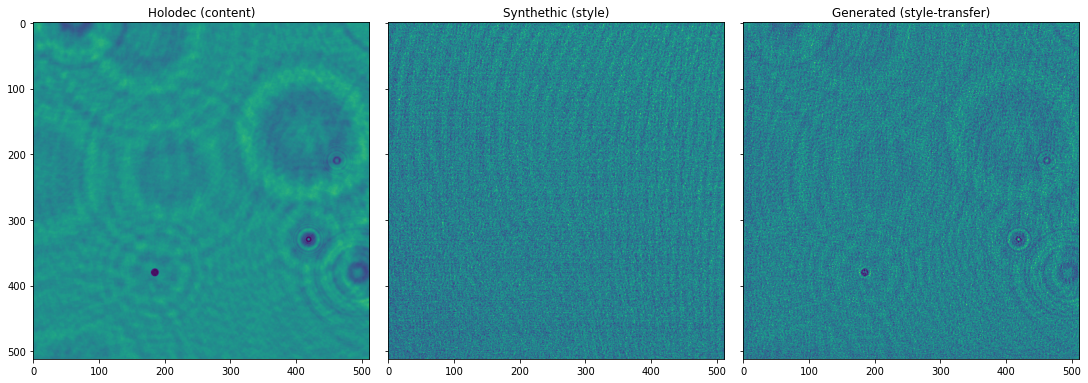

In [72]:
(ax1, ax2, ax3) = plt.figure(constrained_layout=True, figsize = (15, 10)).subplots(1, 3, sharex=True, sharey=True)

ax1.imshow(content_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1)
ax2.imshow(style_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1)
ax3.imshow(output[0][0].detach().cpu().numpy(), vmin=0, vmax=1)


ax1.set_title("Holodec (content)")
ax2.set_title("Synthethic (style)")
ax3.set_title("Generated (style-transfer)")
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [73]:
syn_score = perceptual_alex(style_img, output).mean().item()
holo_score = perceptual_alex(content_img, output).mean().item()
mixed_score = perceptual_alex(content_img, style_img).mean().item()

In [74]:
print(syn_score, holo_score, mixed_score)

0.18030846118927002 0.8297371864318848 0.8631360530853271


0.8730965852737427 0.1808289885520935 0.9055789113044739
0.4756951928138733 0.18503119051456451 0.496830552816391
0.49035972356796265 0.11203087121248245 0.48506540060043335
0.8643295764923096 0.16675089299678802 0.8631360530853271


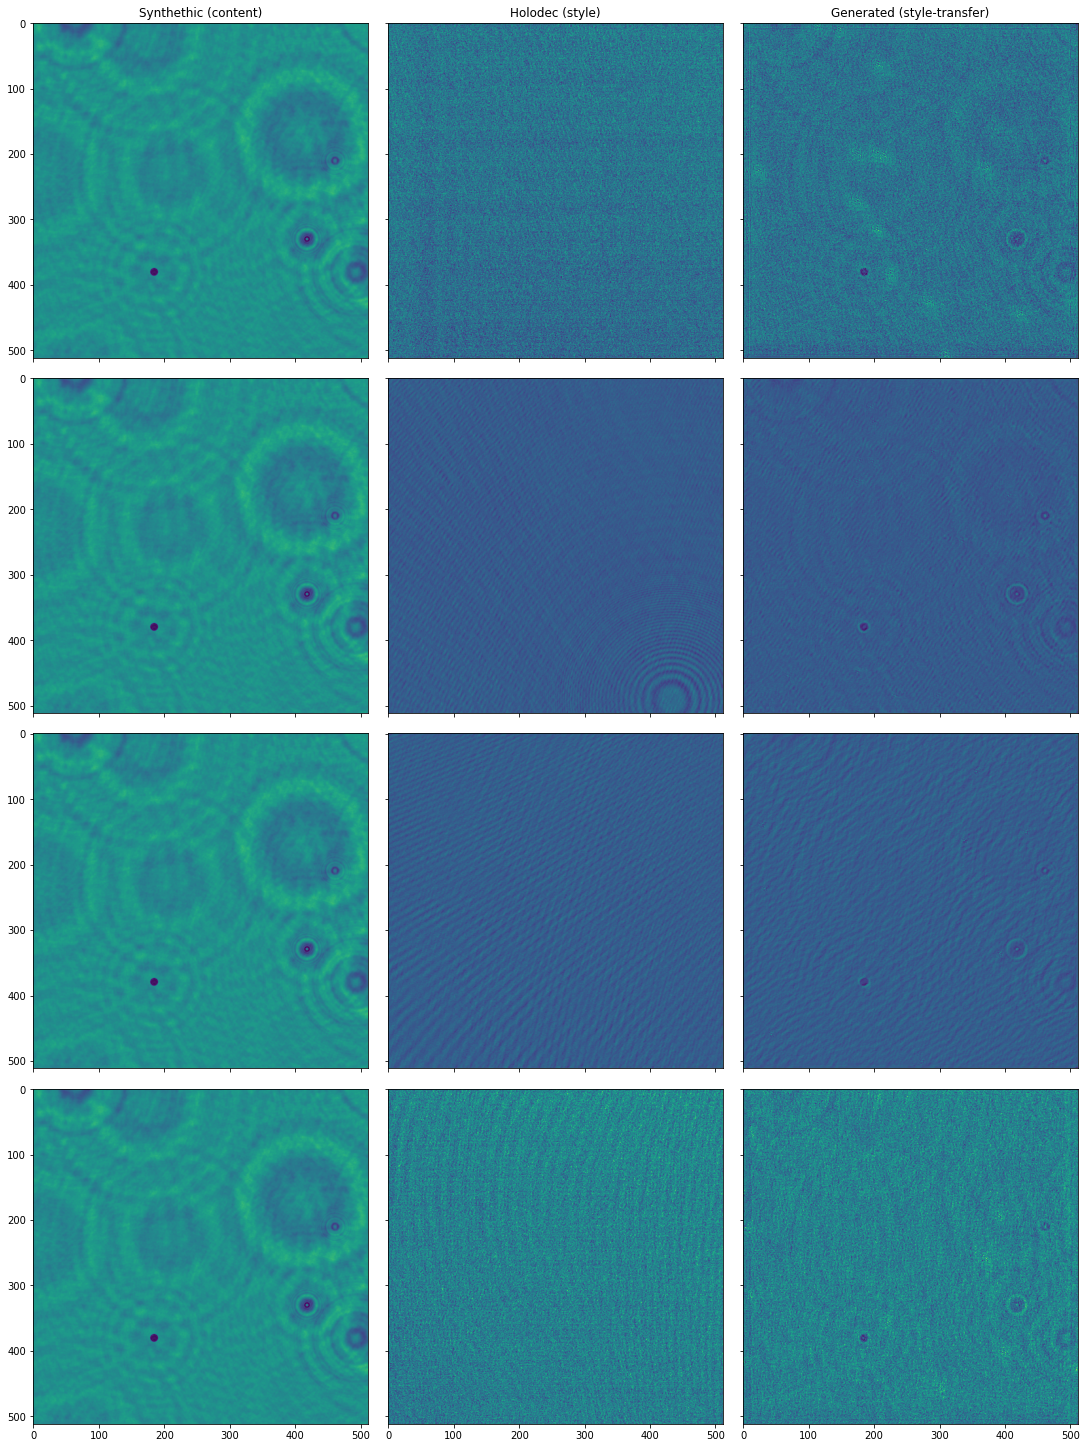

In [76]:
ax = plt.figure(constrained_layout=True, figsize = (15, 20)).subplots(4, 3, sharex=True, sharey=True)

x_s, y_s = train_synthetic_dataset.__getitem__(0)

for i, k in enumerate([123, 46, 82, 1024]):
    x_h, y_h = train_holodec_dataset.__getitem__(k)
    content_img = x_s.clone().unsqueeze(0).to(device).float() / 255.0
    style_img = x_h.clone().unsqueeze(0).to(device).float() / 255.0
    input_img = torch.randn_like(x_s.clone()).unsqueeze(0).to(device).float() / 255.0
 
    output = run_style_transfer(cnn, 
                                content_img, 
                                style_img, 
                                input_img, 
                                style_weight = 1e9,
                                content_weight = 1,
                                verbose = 0,
                                num_steps = 100)
    
    ax1, ax2, ax3 = ax[i]

    ax1.imshow(content_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1)
    ax2.imshow(style_img[0][0].detach().cpu().numpy(), vmin=0, vmax=1)
    ax3.imshow(output[0][0].detach().cpu().numpy(), vmin=0, vmax=1)
    
    syn_score = perceptual_alex(content_img, output).mean().item()
    holo_score = perceptual_alex(style_img, output).mean().item()
    mixed_score = perceptual_alex(content_img, style_img).mean().item()
    
    print(syn_score, holo_score, mixed_score)

    if i == 0:
        ax1.set_title("Synthethic (content)")
        ax2.set_title("Holodec (style)")
        ax3.set_title("Generated (style-transfer)")
        
plt.show()
#plt.savefig("example.pdf", dpi = 300)